# Create dataset which uses HPA metrics as the prediction goal

In [29]:
from typing import List
import pandas as pd
import glob
import os

# Path to the directory containing feather files
hpa_dir = "../../data/minimized_warehouse_7b/"
base_dir = "../../src_predict/03_combined_data/minimized_warehouse_7b/"
output_base_dir = "04_datasets/hpa_7b/"
timezone_difference = 2  # hours (hpa-files and prometheus files were using different timezone for the timestamp


def read_hpa_files() -> List[pd.DataFrame]:
    """
    Load the HPA data to dataframes
    cols = ['timestamp', 'cpu-avg-worker', 'cpu-avg-master', 'replicas-worker',
           'replicas-master']
    """
    hpa_qos_files = glob.glob(os.path.join(hpa_dir, '**', 'hpa_qos.feather'), recursive=True)
    dfs = []
    for hpa_path in hpa_qos_files:
        hpa_df = pd.read_feather(hpa_path)
        hpa_df["timestamp"] = pd.to_datetime(hpa_df["timestamp"]) - pd.Timedelta(hours=timezone_difference)
        dfs.append(hpa_df)
    return dfs


hpa_dfs = read_hpa_files()
hpa_df_concat = pd.concat(hpa_dfs)


def match_hpa(df: pd.DataFrame) -> pd.DataFrame:
    """
    Get the HPA metrics with timestamps matched to the given df
    """
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit="s")
    hpa_cols = hpa_df_concat.columns
    merged_df = pd.merge_asof(
        df.sort_values(by="timestamp"),
        hpa_df_concat.sort_values(by="timestamp"),
        on="timestamp",
        direction="nearest",
        tolerance=pd.Timedelta('5s'),
        suffixes=('_df1', '_df2')
    )
    return merged_df[hpa_cols]


def create_dataset(input_dir, output_path):
    # Initialize an empty list to store individual DataFrames with yolomodel
    dataframes = []

    # Read each feather file
    for file in glob.glob(f"{input_dir}/*.feather"):
        # Read the dataframe
        df = pd.read_feather(file)

        # Add number of workers as a new column
        matched_hpa = match_hpa(df)
        df['target'] = matched_hpa["replicas-worker"]

        # Remove timestamp column, assuming it's named 'timestamp' as a placeholder
        df = df.drop(columns=['timestamp']) if 'timestamp' in df.columns else df

        # Append to the list of DataFrames
        dataframes.append(df)

    # Determine common columns across all DataFrames
    common_columns = list(set.intersection(*(set(df.columns) for df in dataframes)))

    # Standardize each DataFrame to have only columns that are common across all DataFrames
    dataframes = [df[common_columns] for df in dataframes]

    # Combine all DataFrames into a single DataFrame
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    combined_df = pd.concat(dataframes, ignore_index=True)
    combined_df.to_feather(output_path)
    print(f"Saved to {output_path}")
    return combined_df


for folder in os.listdir(base_dir):
    print(folder)
    input_dir = os.path.join(base_dir, folder)
    output_path = os.path.join(output_base_dir, f"{folder}.feather")
    create_dataset(input_dir, output_path)

CPU
Saved to 04_datasets/hpa_7b/CPU.feather
Kepler
Saved to 04_datasets/hpa_7b/Kepler.feather
Disk_io
Saved to 04_datasets/hpa_7b/Disk_io.feather
Memory
Saved to 04_datasets/hpa_7b/Memory.feather
Network
Saved to 04_datasets/hpa_7b/Network.feather
Other
Saved to 04_datasets/hpa_7b/Other.feather


In [30]:
df = pd.read_feather('../../src_predict/03_combined_data/minimized_warehouse_7c/CPU/1738881900_(1.1000).feather')
df["timestamp"] = pd.to_datetime(df['timestamp'], unit="s")
hpa_df = hpa_dfs[0]
print(df["timestamp"])
print(hpa_df["timestamp"])
for hpa in hpa_dfs:
    print(hpa["timestamp"].min())

0       2025-02-06 13:13:08
1       2025-02-06 13:13:13
2       2025-02-06 13:13:18
3       2025-02-06 13:13:23
4       2025-02-06 13:13:28
                ...        
30190   2025-02-06 21:35:58
30191   2025-02-06 21:36:03
30192   2025-02-06 21:36:08
30193   2025-02-06 21:36:13
30194   2025-02-06 21:36:18
Name: timestamp, Length: 30195, dtype: datetime64[ns]
0       2025-02-05 09:44:46
0       2025-02-04 15:41:24
1       2025-02-05 09:44:51
1       2025-02-04 15:41:29
2       2025-02-05 09:44:56
                ...        
19108   2025-02-06 12:43:07
19109   2025-02-06 12:43:12
19110   2025-02-06 12:43:17
19111   2025-02-06 12:43:22
19112   2025-02-06 12:43:27
Name: timestamp, Length: 31893, dtype: datetime64[ns]
2025-02-04 15:41:24


0       NaN
1       NaN
2       NaN
3       NaN
4       NaN
         ..
30190   NaN
30191   NaN
30192   NaN
30193   NaN
30194   NaN
Name: target, Length: 30195, dtype: float64

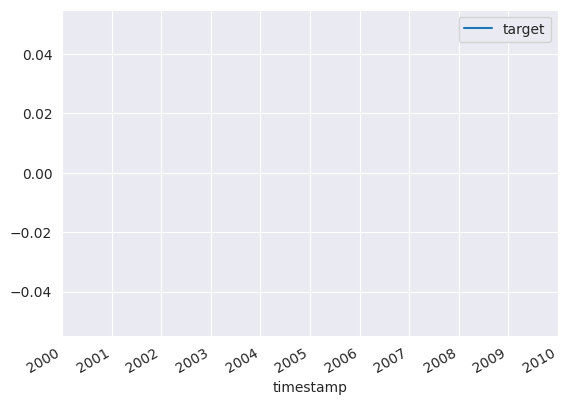

In [31]:
merged_df = pd.merge_asof(
    df.sort_values(by="timestamp"),
    hpa_df.sort_values(by="timestamp"),
    on="timestamp",
    direction="nearest",
    tolerance=pd.Timedelta('5s'),
    suffixes=('_df1', '_df2')
)
merged_df
df["target"] = merged_df["replicas-worker"]
df.plot(x="timestamp", y="target")
df["target"]

In [32]:
a = df["target"]
